In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tqdm import tqdm # Progress Bar
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizer,DistilBertModel
from transformers import TFDistilBertForSequenceClassification
from transformers import AutoTokenizer
from transformers import TextClassificationPipeline
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from transformers import DistilBertTokenizerFast

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import os


import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw= stopwords.words('english')

# Import utility functions
#from src.utils.train_utils import batch_encode

[nltk_data] Downloading package stopwords to /home/titon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
train=pd.read_csv('emotion_train.txt',delimiter=';',header=None,names=['sentence','label'])
test=pd.read_csv('emotion_test.txt',delimiter=';',header=None,names=['sentence','label'])
val=pd.read_csv('emotion_val.txt',delimiter=';',header=None,names=['sentence','label'])

In [26]:
train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [17]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2000 non-null   object
 1   label     2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


df = pd.concat([train,test,val])

In [19]:
df.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [56]:
df.isna().sum()

sentence    0
label       0
count       0
dtype: int64

In [60]:
print(f'there are {df.shape[0]} entries in the data_train')

there are 20000 entries in the data_train


In [25]:
print(f'there are {test.shape[0]} entries in the data_train')

there are 2000 entries in the data_train


# Histogramme pour compter le nombre des mots dans une phrase

In [61]:
# nouvelle colonne count avec la Fonction pour compter le nombre de mot dans une phrase selon le label
# cette new colonne qui nous aide à 
df['count']= df['sentence'].apply(lambda x: len(x.split()))

In [62]:
df.head()

,sentence,label,count
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,21
2,im grabbing a minute to post i feel greedy wrong,anger,10
3,i am ever feeling nostalgic about the fireplac...,love,18
4,i am feeling grouchy,anger,4


<Figure size 720x720 with 0 Axes>

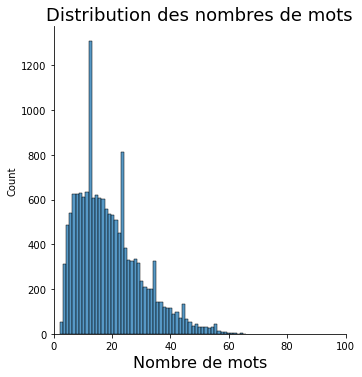

In [65]:
plt.figure(figsize=(10,10))
sns.displot(train['count'])
plt.xlim(0,100)
plt.xlabel('Nombre de mots', fontsize=16)
plt.title('Distribution des nombres de mots',fontsize=18)
plt.show()

In [66]:
label_count=df['label'].value_counts()
label=label_count.index
label

Index(['joy', 'sadness', 'anger', 'fear', 'love', 'surprise'], dtype='object')

In [67]:
label_count

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label, dtype: int64

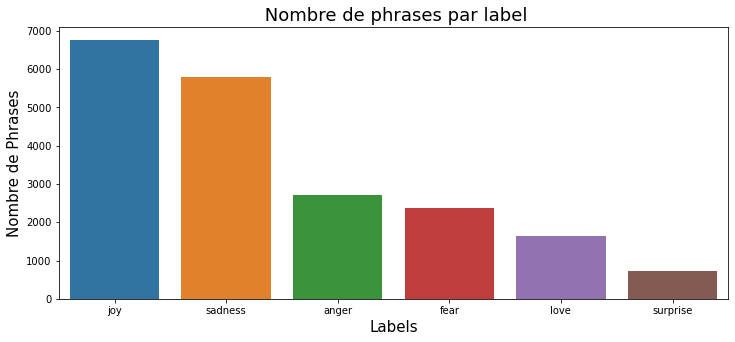

In [68]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(111)
    
sns.barplot(x=label_count.index,y=label_count)
plt.xlabel('Labels',fontsize=15)
plt.ylabel('Nombre de Phrases',fontsize=15)
plt.title(' Nombre de phrases par label', fontsize=18)
plt.show()


In [69]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

# Encodage des labels en variables catégoriques

In [70]:
df['encoded_labels']=df['label'].astype('category').cat.codes
train.head()

,sentence,label,count,encoded_labels
0,i didnt feel humiliated,sadness,4,4
1,i can go from feeling so hopeless to so damned...,sadness,21,4
2,im grabbing a minute to post i feel greedy wrong,anger,10,0
3,i am ever feeling nostalgic about the fireplac...,love,18,3
4,i am feeling grouchy,anger,4,0


# transformation de la colonne Sentence et encode_label en objet list

In [71]:
data_texts  = df['sentence'].to_list()
data_labels = df['encoded_labels'].to_list()

# Train Test Split

In [78]:
# Pour l'entraînement et la validation du modèle
train_text,val_text,train_label,val_label=train_test_split(data_texts,data_labels,test_size=0.2,random_state=0)

# Pour l'entraînement et le test du modèle
train_text,test_text,train_label,test_label=train_test_split(train_text,train_label,test_size=0.01,random_state=0)

# Tokenisation

In [85]:
# Pour trouver le max de token dans nos données d'entraînement
max_val = 0
for sent in (train_text + train_text + val_text):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 85


In [162]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 85

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True,
                                       return_tensors='tf',
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [179]:
X_train_ids, X_train_attention= tokenize(train_text, tokenizer)
X_valid_ids, X_valid_attention= tokenize(val_text, tokenizer)


100%|██████████| 4000/4000 [00:00<00:00, 4480.20it/s]


In [187]:
# Essaie2
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',do_lower_case=True)# Pour charger le tokenizer du modèle
# Encodage des données d'entrainement text en Token
train1_encoding = tokenizer(train_text,truncation=True,padding=True,return_tensors='tf')
val1_encoding= tokenizer(val_text,truncation=True,padding=True,return_tensors='tf')


train_dataset = tf.data.Dataset.from_tensor_slices((
   dict(train1_encoding),
    train_label
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val1_encoding),
     val_label
))

# Essaie 3
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',do_lower_case=True)

# Encode X_train
X3_train_ids, X3_train_attention = (tokenizer, train_text)

# Encode X_valid
X3_valid_ids, X3_valid_attention = (tokenizer,val_text)


# Création du modèle

In [166]:
# Méthode 1

config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
cls_token = embedding_layer[:, 0, :]
X = tf.keras.layers.Dropout(0.2)(cls_token)
X = tf.keras.layers.Dense(6, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 85)]         0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 85)]         0           []                               
                                                                                                  
 tf_distil_bert_model_8 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 85, 768),                                                    
                                 hidden_states=((No                                         

In [235]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Création d'un répertoire pour stocker les poids du modèle 

In [168]:
### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

# Callbacks

In [169]:
model_chekpoint= ModelCheckpoint(filepath= output_dir+'/weihgts.{epoch:02d}.hdf5',
                               save_weights_only=True)
early_stopping= EarlyStopping(patience=3,# stop après 3 epoch
                              monitor='val_loss',# regarder la val_loss
                              mode= 'min',
                              min_delta=0,# changement après 0
                              restore_best_weights=False,
                              verbose=1)


# Compilation + Entraînement

In [170]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
train1_history=model.fit()

In [171]:
train_history= model.fit(x = [X3_train_ids, X3_train_attention],
                         y= train_label,
                         epochs=10,
                         batch_size=16,
                         validation_data=([X3_valid_ids, X3_valid_attention], val_label),
                         callbacks=[model_chekpoint,early_stopping])

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast'>", '(<class \'list\'> containing values of types {"<class \'str\'>"})'}), (<class 'list'> containing values of types {"<class 'int'>"})

# Version 2

In [192]:
MAX_LEN = 85

In [219]:
def distil_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [194]:
X_train, X_val, y_train, y_val = train_test_split(data_texts,data_labels, test_size=0.2, random_state=777)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.01, random_state=777)

In [195]:
tokenizer = TFDistilBertTokenizer.from_pretrained(MODEL_NAME)

In [196]:
X_train = distil_encode(X_train, tokenizer)
X_val = distil_encode(X_val, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_val = np.asarray(y_val, dtype='int32')

In [220]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)


In [234]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')




DistilBERT = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME,config=config)
x = DistilBERT(input_word_ids, attention_mask=input_mask)
x = x[0]

x = tf.keras.layers.Dropout(0.1)(x)
#x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)
model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_360', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 85)]         0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955010   ['input_word_ids[0][0]',         
 assification_3 (TFDistilBertFo  rOutput(loss=None,               'input_mask[0][0]']             
 rSequenceClassification)       logits=(None, 2),                                                 
                                 hidden_states=((No                                        

In [216]:
### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

In [223]:
model_chekpoint= ModelCheckpoint(filepath= output_dir+'/weihgts.{epoch:02d}.hdf5',
                               save_weights_only=True)
early_stopping= EarlyStopping(patience=3,# stop après 3 epoch
                              monitor='val_loss',# regarder la val_loss
                              mode= 'min',
                              min_delta=0,# changement après 0
                              restore_best_weights=False,
                              verbose=1)

In [231]:
model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                        y_train,
                        epochs=5,
                        batch_size=64,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[model_chekpoint,early_stopping]